# Probing Density

In [265]:
import matplotlib.pyplot as plt
import random
random.seed(1337)

On a 1-dimensional interval [0,1] there exists $n$ points. We know nothing the distribution of dots or how many of them there are. However, we do know that there's a minimum distance $d$ between the dots. This is given to us as prior information.

We have one tool to our disposal: a probe. We can give the probe a position $x \in [0,1]$ and it will return the coordinates to the closest left and right dots. We define it as $probe(x): x \in [0,1] \rightarrow (l,r)$ where $l,r \in [0,1]$.

Our task is to approximate the number of dots that's present in the interval. Remember that we can assume nothing about the distribution of dots, as they are placed *arbitrarily*.

### The Probe Function
The probe function looks through the list of (sorted) generated dots and finds the dots left and right of the probed position.

In [2]:
def probe(x, dots):
    N = len(dots)
    for i, dot in enumerate(dots[:-1]):
        if x > dot:
            continue
        else:
            if i - 1 < 0:
                l = None
                r = dots[i]
            else:
                l = dots[i]
                r = dots[i+1]

            return (l,r)
            
    # If we get to the end there's no dots left of x
    return (dots[-1], None)

### The Interval

Let's visualize the interval with dots by placing 50 dots in a uniform random fashion. With the contraint that a point cannot be closer than $d$ from any other point. We'll set $d = 0.05$ for now 

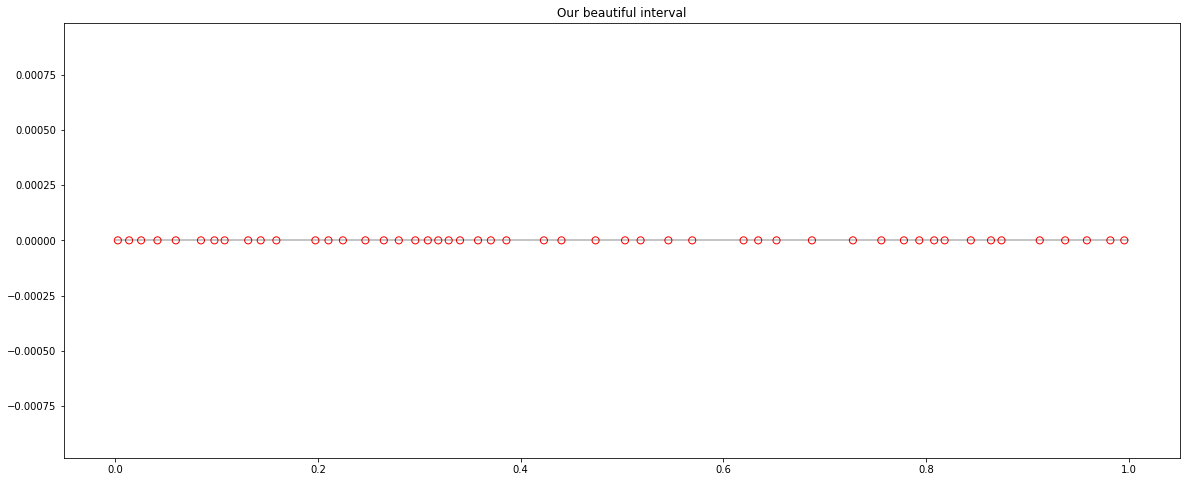

In [307]:
N = 50
d = 0.01
def generate_dots(N, d):
    dots = []
    for i in range(N):
        # not the most efficient but will do for now
        dots.sort()

        if len(dots) < 1:
            x = random.uniform(0,1)
            dots.append(x)
            continue
        
        too_close = True
        while too_close:
            x = random.uniform(0,1)
            too_close = False
            for dot in dots:
                if abs(x - dot) < d:
                    too_close = True
                    break
            
            if not too_close:
                dots.append(x)

    return dots

dots = generate_dots(N,d)

y = [0 for i in range(N)]
plt.figure(figsize=(20,8))
plt.hlines(0,0,1, alpha=0.3)
plt.scatter(dots, y, s=50, facecolors='none', edgecolors='r')
plt.title('Our beautiful interval')
plt.show()

In [308]:
dts = np.array(dots)
dts2 = np.roll(np.copy(dts), -1)
diff = np.abs(dts-dts2)
diff = diff[:-1]
min_dist = diff.min()
max_dist = diff.max()
print("Min distance: %.3f" % min_dist)
print("Max distance: %.3f" % max_dist)

Min distance: 0.010
Max distance: 0.852


## A Simple Randomized Approach

One metric is the mean distance between points, $\bar{d}$. The inverse of $\bar{d}$ can be used to approximate the number of points $\bar{n} = 1 / \bar{d}$. 

One approach is to simply probe the line $k$ times and try to get a mean distance between the dots.

In [309]:
import numpy as np
dots.sort()

def simple_probing(k, a, b):
    distances = []
    
    for i in range(k):
        x = random.uniform(a,b)
        l,r = probe(x, dots)
        # For now we skip edges
        if l and r:
            d = r - l
            distances.append(d)

    if len(distances):
        dists = np.array(distances)
        d_mean = dists.mean()
        return 1 / d_mean
    else:
        return 0


Let's run the simple probing algorithm and see some approximations

In [310]:
approximations = []
for i in range(100):
    n_approx = simple_probing(1000, 0, 1)
    approximations.append(n_approx)

aprx = np.array(approximations)
sd_mean = aprx.mean();
sd_std = aprx.std();
print("Sample Distribution Mean: %.2f" % sd_mean)
print("Sample Distribution STD: %.2f" % sd_std)

Sample Distribution Mean: 47.56
Sample Distribution STD: 0.66


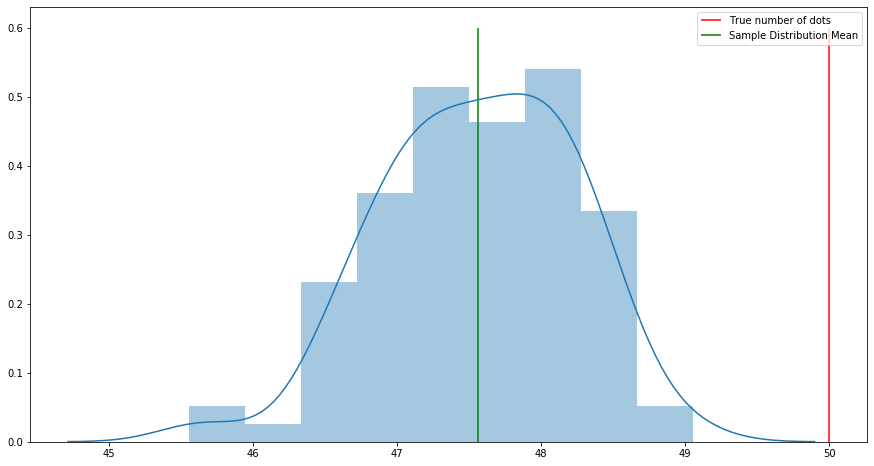

In [314]:
import seaborn as sns
plt.figure(figsize=(15,8))
line_height = 0.6
sns.distplot(aprx);
plt.vlines(N, 0, line_height, colors='r', label='True number of dots')
plt.vlines(aprx.mean(), 0, line_height, colors='g', label='Sample Distribution Mean')
plt.legend()
plt.show()

Looks pretty neat! The barplot makes it look like we're ways off, but in reality we are not.

## Interval Inception

Let's try to divide the interval into... more intervals! And maybe our accuracy will improve.

![InceptionURL](https://media.giphy.com/media/lBtI8rRETmQMg/giphy.gif "inception")

Let's divide the main interval into $m$ subintervals and probe each of them separately.

In [315]:
def create_intervals(m):
    step = 1 / m
    interval_borders = np.arange(0,1 + step, step).round(3)
    intervals = [(i,j) for i,j in zip(interval_borders, interval_borders[1:])]
    return intervals


n_runs = 10
n_intervals = 10
results = []
for i in range(n_runs):
    intervals = create_intervals(n_intervals)
    interval_approximations = []
    for (a,b) in intervals:
        intv_approx = simple_probing(k,a,b)
        interval_approximations.append(intv_approx)
    
    np_ia = np.array(interval_approximations)
    n_approx = np_ia.sum()
    print("Run %d : %.3f" % (i+1, n_approx))
    results.append(n_approx)

Run 1 : 495.040
Run 2 : 496.013
Run 3 : 496.383
Run 4 : 495.670
Run 5 : 494.717
Run 6 : 494.845
Run 7 : 497.060
Run 8 : 500.900
Run 9 : 493.248
Run 10 : 496.902


Interesting! When the dots are uniform we get an overshoot by the amount of interals.